# University vs Fachhochschule classification

In [1]:
import tensorflow as tf
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import sklearn.metrics as metrics

from IPython.display import display 
from PIL import Image

## Data preprocessing

In [2]:
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.9, 1.1),
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=.3
)

test_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)

In [3]:
train_dir = "./data/train"
test_dir = "./data/test"

IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

In [4]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           subset="training")

validation_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           subset="validation")

test_data_gen = test_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                  directory=test_dir,
                                                  target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 164 images belonging to 2 classes.
Found 70 images belonging to 2 classes.
Found 84 images belonging to 2 classes.


In [5]:
train_data_gen.image_shape

(224, 224, 3)

In [6]:
train_data_gen.class_indices

{'FH': 0, 'Uni': 1}

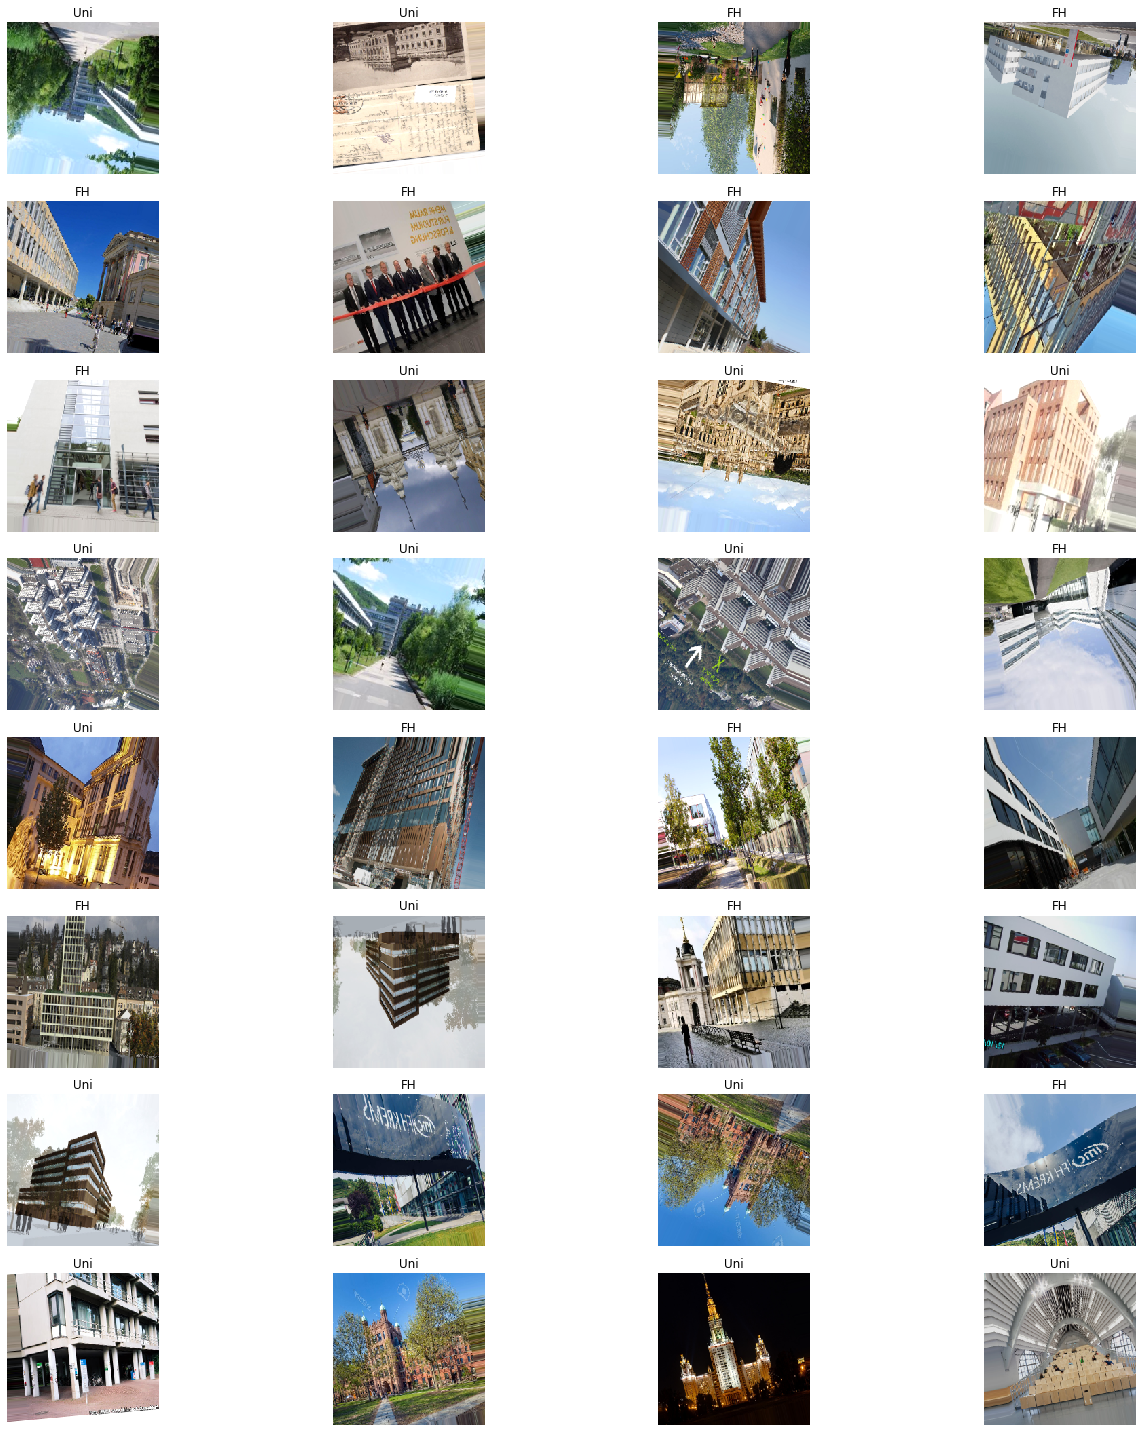

In [7]:
sample_training_images, labels = next(train_data_gen)
class_label = {v:k for k,v in train_data_gen.class_indices.items()}
fig, axes = plt.subplots(8, 4, figsize=(20,20))
axes = axes.flatten()
for img, label, ax in zip(sample_training_images, labels, axes):
    ax.set_title(class_label[np.argmax(label)])
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()

## Classification

In [8]:
def skip_broken_images(gen):
    while True:
        try:
            data, labels = next(gen)
            yield data, labels
        except GeneratorExit:
            break
        except:
            pass

### AlexNet (somewhat)

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    
    tf.keras.layers.Convolution2D(filters=96, kernel_size=(11,11), strides=(4,4)),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    
    tf.keras.layers.Convolution2D(filters=256, kernel_size=(5,5), padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    
    tf.keras.layers.Convolution2D(filters=384, kernel_size=(3,3), padding='same'),
    tf.keras.layers.Convolution2D(filters=384, kernel_size=(3,3), padding='same'),
    tf.keras.layers.Convolution2D(filters=256, kernel_size=(3,3), padding='same'),
    
#     providing a softmax layer yielded really good results on the training data
     tf.keras.layers.Softmax(axis = -1),
#     tf.keras.layers.UpSampling2D(size = (2, 2), interpolation = 'nearest'),
    
    tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    
    tf.keras.layers.Flatten(),
            
    tf.keras.layers.Dense(512, activation='relu', name="fc4096a"),            
#     tf.keras.layers.Dense(256, activation='relu', name="fc4096b"),            
    tf.keras.layers.Dense(2, activation='softmax', name="fc1000")
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 54, 54, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 384)       885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 384)       1327488   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 256)       8

In [10]:
history = None

In [11]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.3,
    patience=3)

In [12]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

history = model.fit_generator(
    skip_broken_images(train_data_gen),
    steps_per_epoch=train_data_gen.samples // BATCH_SIZE,
    epochs=30,
    validation_data=skip_broken_images(validation_data_gen),
    validation_steps=validation_data_gen.samples // BATCH_SIZE,
    callbacks=[earlystop_callback])

Epoch 1/30
5/5 [==============================] - 22s 4s/step - loss: 0.6119 - categorical_accuracy: 0.5530 - val_loss: 0.7083 - val_categorical_accuracy: 0.6250
Epoch 2/30
5/5 [==============================] - 22s 4s/step - loss: 0.7161 - categorical_accuracy: 0.6313 - val_loss: 0.6458 - val_categorical_accuracy: 0.6579
Epoch 3/30
5/5 [==============================] - 20s 4s/step - loss: 0.6779 - categorical_accuracy: 0.6212 - val_loss: 0.6459 - val_categorical_accuracy: 0.7632
Epoch 4/30
5/5 [==============================] - 19s 4s/step - loss: 0.6780 - categorical_accuracy: 0.6439 - val_loss: 0.6169 - val_categorical_accuracy: 0.7105


### Save and restore

In [13]:
model.save("model-1.h5")

In [14]:
model = tf.keras.models.load_model("model-1.h5")

### Model evaluation

In [15]:
def test_model(model, test_data_gen, history):
    if history is not None:
        plt.figure(0)
        plt.plot(history.history['loss'], label="loss")
        plt.plot(history.history['val_loss'], label="val_loss Loss")
        plt.legend(loc='best')
        plt.show()

        plt.figure(1)
        plt.plot(history.history['categorical_accuracy'], label="accuracy")
        plt.plot(history.history['val_categorical_accuracy'], label="val_accuracy")
        plt.legend(loc='best')
        plt.show()
    
    print("Evaluating model...")
    score = model.evaluate_generator(test_data_gen, steps=test_data_gen.samples / BATCH_SIZE)

    print("Loss: ", score[0])
    print("Classification accuracy:", score[1])
    
    print()
    
    # confusion matrix
    print("Predicting test data...")
    y_pred = model.predict_generator(test_data_gen, steps=test_data_gen.samples / BATCH_SIZE)

    y_pred = np.argmax(y_pred, axis=1)
    y_true = test_data_gen.classes
    
    c_matrix = metrics.confusion_matrix(y_true, y_pred)
    print(c_matrix)
    
    print()
    
    # ROC and AUC
    print("Calculating and plotting ROC and AUC...")
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    auc = metrics.auc(fpr, tpr)
    
    print("AUC score: ", auc)
    
    plt.figure(2)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='Model (area = {:.3f})'.format(auc))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

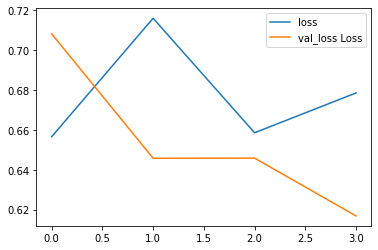

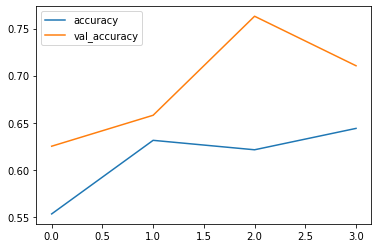

Evaluating model...
Loss:  0.8231947989690871
Classification accuracy: 0.47619048

Predicting test data...
[[ 0 44]
 [ 0 40]]

Calculating and plotting ROC and AUC...
AUC score:  0.5


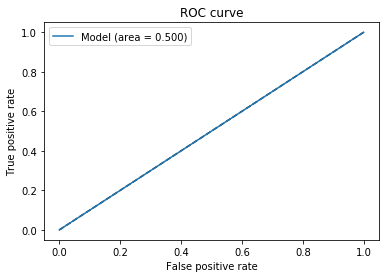

In [16]:
test_model(model, test_data_gen, history)

**Observation**: The model does not perform really well with the provided data. Though we also tested it with a Cats and Dogs dataset and it did perform better but not as expected. We excepted a classification accuracy of at least 70% on test data for that dataset but only got to about 60%. This leads us to believe that the model is to simple ro that the data is to hard, or both. 

From just looking at both a FH and a Uni building one does not know which is which, so it must be hard for the model as well.

### Predefined network

In [17]:
base_model = tf.keras.applications.resnet_v2.ResNet50V2(
        include_top=False,
        pooling='max',
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        weights='imagenet')

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(512, 'relu'),
    tf.keras.layers.Dense(256, 'relu'),
    tf.keras.layers.Dense(train_data_gen.num_classes, 'softmax')
])
    
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 24,745,730
Trainable params: 24,700,290
Non-trainable params: 45,440
_________________________________________________________________


In [18]:
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

history = model.fit_generator(
    skip_broken_images(train_data_gen),
    steps_per_epoch=train_data_gen.samples // BATCH_SIZE,
    epochs=30,
    validation_data=skip_broken_images(validation_data_gen),
    validation_steps=validation_data_gen.samples // BATCH_SIZE,
    callbacks=[earlystop_callback])

Epoch 1/30
5/5 [==============================] - 104s 21s/step - loss: 6.9384 - categorical_accuracy: 0.4091 - val_loss: 10.1578 - val_categorical_accuracy: 0.3947
Epoch 2/30
5/5 [==============================] - 103s 21s/step - loss: 10.9031 - categorical_accuracy: 0.3788 - val_loss: 8.4788 - val_categorical_accuracy: 0.3421
Epoch 3/30
5/5 [==============================] - 122s 24s/step - loss: 10.0738 - categorical_accuracy: 0.3750 - val_loss: 8.2269 - val_categorical_accuracy: 0.3684
Epoch 4/30
5/5 [==============================] - 102s 20s/step - loss: 10.8370 - categorical_accuracy: 0.3409 - val_loss: 9.5701 - val_categorical_accuracy: 0.3421
Epoch 5/30
5/5 [==============================] - 107s 21s/step - loss: 10.0026 - categorical_accuracy: 0.4015 - val_loss: 10.3257 - val_categorical_accuracy: 0.3594


### Save and restore

In [19]:
model.save("model-2.h5")

In [20]:
model = tf.keras.models.load_model("model-2.h5")

### Model evaluation

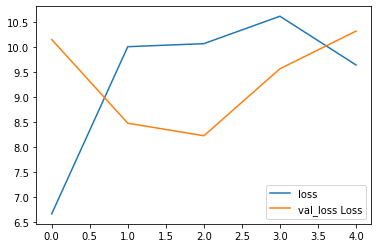

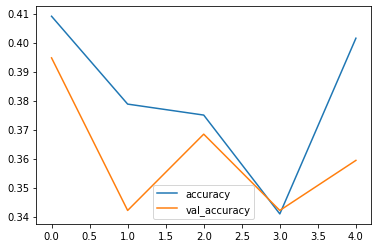

Evaluating model...
Loss:  8.481188274565197
Classification accuracy: 0.52380955

Predicting test data...
[[44  0]
 [40  0]]

Calculating and plotting ROC and AUC...
AUC score:  0.5


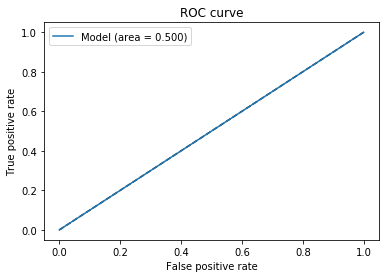

In [21]:
test_model(model, test_data_gen, history)

### ResNet (somewhat)

In [22]:
inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

#Block 1
x = tf.keras.layers.Conv2D(32, 3, activation='relu', name='block_1_conv_1')(inputs)
x = tf.keras.layers.Conv2D(64, 3, activation='relu', name='block_1_conv_2')(x)
block_1_output = tf.keras.layers.MaxPooling2D(3, name='block_1_maxpool')(x)

#Block 2
x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', name='block_2_conv_1')(block_1_output)
x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', name='block_2_conv_2')(x)
block_2_output = tf.keras.layers.add([x, block_1_output], name='block_1_add_block_2')

#Block 3
x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', name='block_3_conv_1')(block_2_output)
x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', name='block_3_conv_2')(x)
block_3_output = tf.keras.layers.add([x, block_2_output], name='block_2_add_block_3')

#Network tail
x = tf.keras.layers.Conv2D(64, 3, activation='relu')(block_3_output)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs, name='resnet')
model.summary()

Model: "resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block_1_conv_1 (Conv2D)         (None, 222, 222, 32) 896         input_3[0][0]                    
__________________________________________________________________________________________________
block_1_conv_2 (Conv2D)         (None, 220, 220, 64) 18496       block_1_conv_1[0][0]             
__________________________________________________________________________________________________
block_1_maxpool (MaxPooling2D)  (None, 73, 73, 64)   0           block_1_conv_2[0][0]             
_____________________________________________________________________________________________

In [23]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

history = model.fit_generator(
    skip_broken_images(train_data_gen),
    steps_per_epoch=train_data_gen.samples // BATCH_SIZE,
    epochs=30,
    validation_data=skip_broken_images(validation_data_gen),
    validation_steps=validation_data_gen.samples // BATCH_SIZE,
    callbacks=[earlystop_callback])

Epoch 1/30
5/5 [==============================] - 54s 11s/step - loss: 0.6828 - categorical_accuracy: 0.6212 - val_loss: 0.6450 - val_categorical_accuracy: 0.6316
Epoch 2/30
5/5 [==============================] - 52s 10s/step - loss: 0.6486 - categorical_accuracy: 0.6288 - val_loss: 0.6287 - val_categorical_accuracy: 0.7105
Epoch 3/30
5/5 [==============================] - 64s 13s/step - loss: 0.6555 - categorical_accuracy: 0.6375 - val_loss: 0.6743 - val_categorical_accuracy: 0.6250
Epoch 4/30
5/5 [==============================] - 52s 10s/step - loss: 0.7043 - categorical_accuracy: 0.5985 - val_loss: 0.6564 - val_categorical_accuracy: 0.6842


### Save and restore

In [24]:
model.save("model-3.h5")

In [25]:
model = tf.keras.models.load_model("model-3.h5")

### Model evaluation

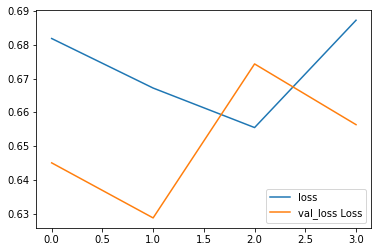

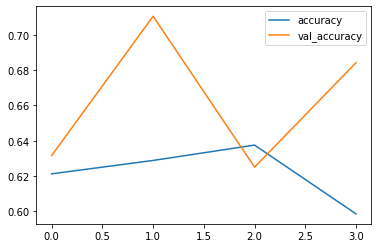

Evaluating model...
Loss:  0.8042851175580706
Classification accuracy: 0.47619048

Predicting test data...
[[ 0 44]
 [ 0 40]]

Calculating and plotting ROC and AUC...
AUC score:  0.5


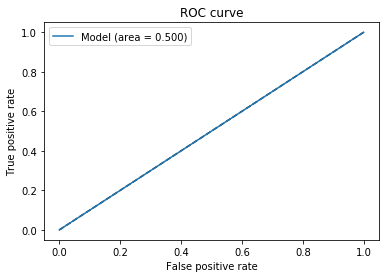

In [26]:
test_model(model, test_data_gen, history)

**Conclusion**:
This project can be seen as an antipattern for the provided data. No matter how complex the model is, if the data provided is not seperable via its features the model will not achieve good results.

**Pitfalls**: 
* In the future we would want to install Jupyter on a Linux machine (Docker or on the host itself) or on Windows itself without using Docker. This would allow us to use the GPU for the model training which would be quite fruitfull. Unfortunately Docker for Windows does not have GPU support yet(Thanks HyperV...)
* no good method for importing data and splitting it into training, validation and test set from keras, only for validation and training. We had to manually use a test folder. We could've used scikit for this but still this is something that should be included in the keras API
* 'history' of training the model is not saved with model. So to show the loss graph of training one would always have to train it again. Would be cool for such stuff to be stored on the metric as well